In [26]:
import uproot3 as uproot
import uproot_methods
import uproot_methods.classes.TLorentzVector as LVepm
import matplotlib.pyplot as plt
import time
import infofile
import numpy as np
import mplhep as hep
from scipy import stats
import boost_histogram as bh
import pandas as pd

In [152]:
samples = ["wzcc", "wzbb", "ttz", "twz"]

xsecs= [785, 973, 759, 116]

#BR = [ (0.034 + 0.034) * (0.11 + 0.11),
#       (0.034 + 0.034) * (0.11 + 0.11),
#       (0.034 + 0.034) * (0.11 + 0.11),
#       (0.034 + 0.034) * (0.11 + 0.11)
#     ]

BR = [ (0.034 + 0.034) * (0.11 + 0.11),
       (0.034 + 0.034) * (0.11 + 0.11),
       (0.22 * 0.78)*(2)*(0.068),
       (0.22 * 0.78)*(2)*(0.068)
     ]





intLumi = 3000.0
n_events = 30000

bins_z_mass = np.linspace(60.0, 120.0, num=30)
bins_z_pt = np.linspace(0.0, 300.0, num=4)
bins_ht = np.linspace(0.0, 2000.0, num=15)
bins_met = np.linspace(0.0, 300.0, num=15)
bins_bjj_mass = np.linspace(0.0, 700.0, num=10)

In [ ]:
plot_z_mass = []
plot_z_pt = []
plot_z_pt_true = []
plot_ht = []
plot_met = []
plot_bjj_mass = []

for isample in range(0, len(samples)):

    n_mumu_cand = np.array([])
    mumu_cand_masses = np.array([])
    mumu_cand_pts = np.array([])

    n_elel_cand = np.array([])
    elel_cand_masses = np.array([])
    elel_cand_pts = np.array([])

    sample_name = str("delphes_output_") + str(samples[isample]) + str("_3l.root")
    eventsData = uproot.open(sample_name)["Delphes"] 
    EventCrossSection, JetPT, JetEta, JetPhi, JetBTag, HT, MET, MuonPT, MuonEta, MuonPhi, MuonT, MuonCharge, MuonIsolationVar, MuonDZ, ElectronPT, ElectronEta,  ElectronPhi,  ElectronT, ElectronCharge, ElectronIsolationVar, ParticlePID, ParticleStatus, ParticleMass, ParticlePT = eventsData.arrays(["Event.CrossSection","Jet.PT", "Jet.Eta","Jet.Phi", "Jet.BTag", "ScalarHT.HT", "MissingET.MET", "Muon.PT", "Muon.Eta", "Muon.Phi", "Muon.T", "Muon.Charge", "Muon.IsolationVar", "Muon.DZ", "Electron.PT", "Electron.Eta", "Electron.Phi", "Electron.T", "Electron.Charge", "Electron.IsolationVar", "Particle.PID", "Particle.Status","Particle.Mass", "Particle.PT"],outputtype=tuple)

    EventIDs = np.arange(0, len(EventCrossSection), 1, dtype=int) 
    
    evWeight = (xsecs[isample] * BR[isample] * intLumi)/n_events
   
    #object-level cuts
    e_cut  = (ElectronPT>15) & (ElectronIsolationVar<0.1) & ( abs(ElectronEta)< 4)
    mu_cut  = (MuonPT>15) & (MuonIsolationVar<0.1) & ( abs(MuonEta)< 4)
    jet_cut  = (JetPT>20) & (abs(JetEta)< 4.5)
    btag_cut  = (JetBTag==1)
    
    #event-level cuts    
    n_lep_cut = ( ( (ElectronPT[e_cut].counts) + (MuonPT[mu_cut].counts))== 3) 
    sum_charge_cut =  ((ElectronCharge[e_cut].sum()) + (MuonCharge[mu_cut].sum()) <3 )
    njet_cut = (JetPT[jet_cut].counts >= 3)
    nbtag_cut = (JetPT[jet_cut & btag_cut].counts >= 1)
    
    # flat event cut
    event_cut = (n_lep_cut & sum_charge_cut & njet_cut & nbtag_cut)
    
    #Get true Z pt for all events
    EventNumber, ParticlefUniqueID, ParticlePID, ParticleM1, ParticleStatus, ParticleMass, ParticlePT, ParticleEta, ParticlePhi = eventsData.arrays(["Event.Number", "Particle.fUniqueID", "Particle.PID", "Particle.M1", "Particle.Status","Particle.Mass", "Particle.PT", "Particle.Eta", "Particle.Phi"], outputtype=tuple)
    z_pt_true = ParticlePT[(ParticlePID==23) & (ParticleStatus==62)]
    #print(z_pt_true)

    #Get Unique Event IDs of events passing the baseline selection
    selected_event_IDs = EventIDs[event_cut]
    print("Number of baseline-selected events = " + str(len(selected_event_IDs)) )
    
    #Make array with len = total events and all values
    z_pt_reco = np.full(len(EventCrossSection), -1)
    z_mass_reco = np.full(len(EventCrossSection), -1)
    
    print(JetPT[event_cut])
    print(JetPT[event_cut,0])
    
    j1_lv = LVepm.TLorentzVectorArray.from_ptetaphim(JetPT[event_cut,0],JetEta[event_cut,0],JetPhi[event_cut,0],0.0)
    j2_lv = LVepm.TLorentzVectorArray.from_ptetaphim(JetPT[event_cut,1],JetEta[event_cut,1],JetPhi[event_cut,1],0.0)
    j3_lv = LVepm.TLorentzVectorArray.from_ptetaphim(JetPT[event_cut,2],JetEta[event_cut,2],JetPhi[event_cut,2],0.0)

    bjj_lv = j1_lv + j2_lv + j3_lv
    
    # Loop over the baseline-selected events and search for Z candidates
    for sel_ev in range (0, len(EventIDs[event_cut])):
        sel_ev_ID = selected_event_IDs[sel_ev]
        
        mumu_pt = -1.0
        mumu_mass = -1.0

        #find Z->mumu candidates
        sel_mu_pt   = MuonPT[sel_ev_ID]
        sel_mu_eta  = MuonEta[sel_ev_ID]
        sel_mu_phi  = MuonPhi[sel_ev_ID]

        sel_mu_m_pt   = MuonPT[MuonCharge ==-1][sel_ev_ID]
        sel_mu_m_eta  = MuonEta[MuonCharge ==-1][sel_ev_ID]
        sel_mu_m_phi  = MuonPhi[MuonCharge ==-1][sel_ev_ID] 
    
        sel_mu_p_pt   = MuonPT[MuonCharge ==1][sel_ev_ID]
        sel_mu_p_eta  = MuonEta[MuonCharge ==1][sel_ev_ID]
        sel_mu_p_phi  = MuonPhi[MuonCharge ==1][sel_ev_ID] 
        
        #make mu+ mu- combinations
        for mum in range(0, len(sel_mu_m_pt)):            
            mu_m_lv = LVepm.TLorentzVector.from_ptetaphim(sel_mu_m_pt[mum],sel_mu_m_eta[mum],sel_mu_m_phi[mum], 0.0)
            for mup in range(0, len(sel_mu_p_pt)):
                mu_p_lv = LVepm.TLorentzVector.from_ptetaphim(sel_mu_p_pt[mup],sel_mu_p_eta[mup],sel_mu_p_phi[mup], 0.0)
                mumu_lv = mu_m_lv + mu_p_lv
                if ((mumu_lv.mass > 60.0) & (mumu_lv.mass < 120.0)):
                    mumu_pt = mumu_lv.pt
                    mumu_mass = mumu_lv.mass
                    z_lv = mumu_lv
                    
        #find Z->ee candidates
        ee_pt = -1.0
        ee_mass = -1.0

        sel_e_pt   = ElectronPT[sel_ev_ID]
        sel_e_eta  = ElectronEta[sel_ev_ID]
        sel_e_phi  = ElectronPhi[sel_ev_ID]

        sel_e_m_pt   = ElectronPT[ElectronCharge ==-1][sel_ev_ID]
        sel_e_m_eta  = ElectronEta[ElectronCharge ==-1][sel_ev_ID]
        sel_e_m_phi  = ElectronPhi[ElectronCharge ==-1][sel_ev_ID] 
    
        sel_e_p_pt   = ElectronPT[ElectronCharge ==1][sel_ev_ID]
        sel_e_p_eta  = ElectronEta[ElectronCharge ==1][sel_ev_ID]
        sel_e_p_phi  = ElectronPhi[ElectronCharge ==1][sel_ev_ID] 
        
        #make e+ e- combinations
        for em in range(0, len(sel_e_m_pt)):            
            e_m_lv = LVepm.TLorentzVector.from_ptetaphim(sel_e_m_pt[em],sel_e_m_eta[em],sel_e_m_phi[em], 0.0)
            for ep in range(0, len(sel_e_p_pt)):
                e_p_lv = LVepm.TLorentzVector.from_ptetaphim(sel_e_p_pt[ep],sel_e_p_eta[ep],sel_e_p_phi[ep], 0.0)
                ee_lv = e_m_lv + e_p_lv
                if ((ee_lv.mass > 60.0) & (ee_lv.mass < 120.0)):
                    ee_pt = ee_lv.pt
                    ee_mass = ee_lv.mass
                    z_lv = ee_lv
    
        #print("4 Change array entries to Zpt values")
        if (mumu_pt != -1):
            z_pt_reco[sel_ev_ID] = mumu_pt
            z_mass_reco[sel_ev_ID] = mumu_mass
        elif (ee_pt != -1):
            z_pt_reco[sel_ev_ID] = ee_pt
            z_mass_reco[sel_ev_ID] = ee_mass

    print("Number of fully-selected events = " + str(len(z_mass_reco[z_mass_reco>0])))
    
    
    H_z_mass, b = np.histogram(z_mass_reco, weights=np.full(len(z_mass_reco),evWeight), bins=bins_z_mass)
    H_z_pt, b = np.histogram(z_pt_reco, weights=np.full(len(z_pt_reco), evWeight), bins=bins_z_pt)
    H_z_pt_true, b = np.histogram(z_pt_true, weights=np.full(len(z_pt_reco), evWeight), bins=bins_z_pt)
    H_ht, b = np.histogram(HT[event_cut], weights=np.full(len(HT[event_cut]), evWeight), bins=bins_ht)
    H_met, b = np.histogram(MET[event_cut], weights=np.full(len(MET[event_cut]), evWeight), bins=bins_met)
    H_bjj_mass, b = np.histogram(bjj_lv.mass, weights=np.full(len(bjj_lv.mass), evWeight), bins=bins_bjj_mass)

    plot_z_pt.append(H_z_pt)
    plot_z_pt_true.append(H_z_pt_true)
    plot_z_mass.append(H_z_mass)       
    plot_ht.append(H_ht)
    plot_met.append(H_met)
    plot_bjj_mass.append(H_bjj_mass)
    
    if (samples[isample] == "twz"):               
        csv_true_name = "/Users/jameskeaveney/DockerRoot/RooUnfold/z_pt_true_" + str(samples[isample]) + ".csv"
        csv_reco_name = "/Users/jameskeaveney/DockerRoot/RooUnfold/z_pt_reco_" + str(samples[isample]) + ".csv"
        np.savetxt(csv_true_name, z_pt_true, delimiter=",")
        np.savetxt(csv_reco_name, z_pt_reco, delimiter=",")    

Number of baseline-selected events = 35
[[123.57399 108.98905 28.37255] [124.87208 67.39126 67.046745 33.45144 26.648052] [69.69313 48.22303 27.958239 27.679794] ... [92.782715 32.381283 29.184738] [77.67467 68.84183 39.25104] [170.68939 119.63159 25.13675]]
[123.57399  124.87208   69.69313  110.84868  128.90833   94.93843
 196.42075  109.966545 314.0751   199.88612   39.837955 469.95624
 213.90059  705.2938   164.60799   88.97633  257.4786   128.6809
  83.80929   88.17105  186.80113   55.62699  201.56163  432.18506
 255.65746   70.55874  170.95589  107.65696   71.95477  139.35385
 170.16963  110.52206   92.782715  77.67467  170.68939 ]
Number of fully-selected events = 34
Number of baseline-selected events = 91
[[89.87091 53.910103 36.70597] [105.64349 68.23687 48.74986] [85.45971 71.22016 60.332634 34.66725 28.432255] ... [160.18227 32.846992 32.642937] [111.99946 110.05876 42.62995] [59.9558 38.408455 33.362507 30.329653]]
[ 89.87091  105.64349   85.45971  277.39917  153.04134   45.

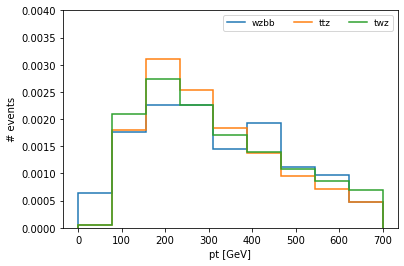

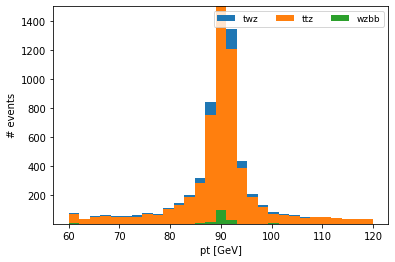

[1.15728222e-04 8.43666312e-05 2.99285765e-05]
 
[1.80362087e-05 1.24112176e-05 4.94142705e-06]
 
[2438.527872 1777.702784  630.629824]
[46969.96735199 26990.84995201  8197.04028   ]
 


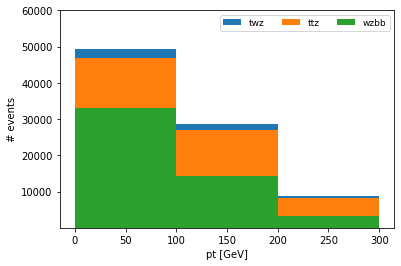

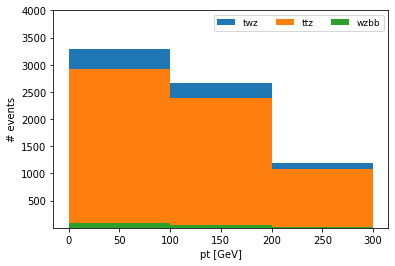

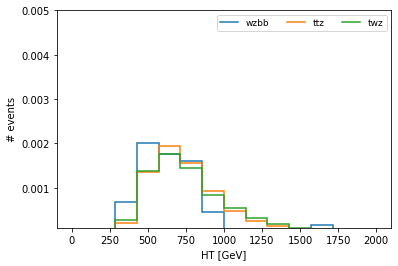

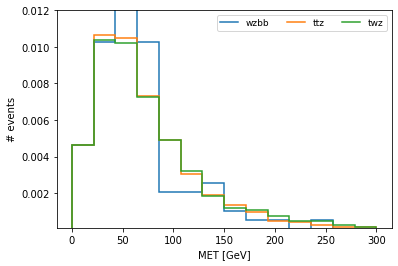

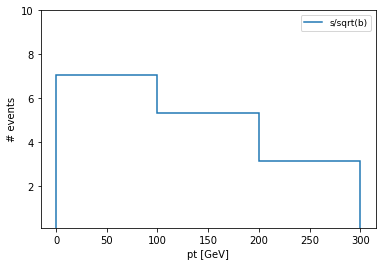

In [151]:
#bin_width = bins_ll_pt[1] - bins_ll_pt[0]
#diff_xs = plot_ll_pt[0]/(intLumi*bin_width)#


plt.figure()
hep.histplot(plot_bjj_mass, bins=bins_bjj_mass, stack=False, density=True, label=samples, histtype='step')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("pt [GeV]")
plt.ylabel("# events")
#plt.yscale('log')
plt.ylim([0.0, 0.004])
plt.show()


plt.figure()
hep.histplot(plot_z_mass, bins=bins_z_mass, stack=True, label=samples, histtype='fill')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("pt [GeV]")
plt.ylabel("# events")
#plt.yscale('log')
plt.ylim([0.1, 1500])
plt.show()


bin_width = bins_z_pt[1] - bins_z_pt[0]
print(plot_z_pt_true[2]/(BR[2] *  intLumi * n_events * (4695/30000) * bin_width ))
print(" ")


print(plot_z_pt[2]/(BR[2] *  intLumi * n_events * (4695/30000)  * bin_width ))
#print(plot_z_pt[0] + plot_z_pt[1])
print(" ")


print(plot_z_pt_true[2])
print(plot_z_pt_true[0] + plot_z_pt_true[1])
print(" ")


plt.figure()
hep.histplot(plot_z_pt_true, bins=bins_z_pt, stack=True, label=samples, histtype='fill')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("pt [GeV]")
plt.ylabel("# events")
plt.ylim([0.1, 60000])
plt.show()




plt.figure()
hep.histplot(plot_z_pt, bins=bins_z_pt, stack=True, label=samples, histtype='fill')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("pt [GeV]")
plt.ylabel("# events")
plt.ylim([0.1, 4000])
plt.show()

plt.figure()
hep.histplot(plot_ht, bins=bins_ht, stack=False, density=True, label=samples, histtype='step')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("HT [GeV]")
plt.ylabel("# events")
plt.ylim([0.0001, 0.005])
plt.show()

plt.figure()
hep.histplot(plot_met, bins=bins_met, stack=False, density=True, label=samples, histtype='step')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("MET [GeV]")
plt.ylabel("# events")
plt.ylim([0.0001, 0.012])
plt.show()


#s/sqrtb()
s_sqrt_b = plot_z_pt[2] / ( np.sqrt( plot_z_pt[0] + plot_z_pt[1]   )  )

plt.figure()
hep.histplot(s_sqrt_b, bins=bins_z_pt, stack=True, label="s/sqrt(b)", histtype='step')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("pt [GeV]")
plt.ylabel("# events")
plt.ylim([0.1, 10])
plt.show()
